# ICESat-2 Data

Here, we attempt to map ICESat-2 data into an Xarray, so that we may compare it with other raster data. We use **Icepyx** and **SlideRule** for the data downloading process.

First, we need a bunch of modules to efficiently download and analyze the data:

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import os
from IPython.display import Image
from IPython.core.display import HTML 
import hvplot
import hvplot.dask
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray
import s3fs
import xarray
import rasterio
import rasterio.plot
import sys
import seaborn as sns
import glob
from shapely.geometry import Polygon

try:  #may not need
    import lxml
except Exception:
    !pip install lxml

# Icepyx modules
import requests
import icepyx as ipx

# Sliderule modules
from sliderule import icesat2

We then initialize our data request. A query is generated using Icepyx to gather ATL03 data over Grand Mesa. The request is valid for December 1, 2018 - June 6, 2021. Credit goes to Ben Smith for this code.

In [24]:
# GDAL environment variables to efficiently read remote data
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

# SAR Data are stored in a public S3 Bucket
url = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# These Cloud-Optimized-Geotiff (COG) files have 'overviews', low-resolution copies for quick visualization
XR=[725000.0, 767000.0]
YR=[4.30e6, 4.34e6]
# open the dataset
da = rioxarray.open_rasterio(url, overview_level=1).squeeze('band')#.clip_box([712410.0, 4295090.0, 797010.0, 4344370.0])
da=da.where((da.x>XR[0]) & (da.x < XR[1]), drop=True)
da=da.where((da.y>YR[0]) & (da.y < YR[1]), drop=True)
dx=da.x[1]-da.x[0]
SAR_extent=[da.x[0]-dx/2, da.x[-1]+dx/2, np.min(da.y)-dx/2, np.max(da.y)+dx/2]

# Prepare coordinate transformations into the basemap coordinate system
from pyproj import Transformer, CRS
crs=CRS.from_wkt(da['spatial_ref'].spatial_ref.crs_wkt)
to_image_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lon, corners_lat=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
lonlims=[np.min(corners_lat), np.max(corners_lat)]
latlims=[np.min(corners_lon), np.max(corners_lon)]

In [25]:
# Generate the query
region_a = ipx.Query('ATL03', [lonlims[0], latlims[0], lonlims[1], latlims[1]], ['2018-12-01','2021-06-01'], \
                          start_time='00:00:00', end_time='23:59:59')

# Earthdata authentication
# earthdata_uid = 'zhfair'
# email = 'zhfair@umich.edu'
# region_a.earthdata_login(earthdata_uid, email)

In [26]:
# Quickly view some of the available granules
ATLAS_re=re.compile('ATL.._(?P<year>\d\d\d\d)(?P<month>\d\d)(?P<day>\d\d)\d+_(?P<track>\d\d\d\d)')
region_a.avail_granules()
date_track=[]
for count, item in enumerate(region_a.granules.avail):
    granule_info=ATLAS_re.search(item['producer_granule_id']).groupdict()
    date_track += [ ('-'.join([granule_info[key] for key in ['year', 'month', 'day']]), granule_info['track'])]

# print the first ten dates and ground tracks, plus their indexes
[(count, dt) for count, dt in enumerate(date_track[0:10])]

[(0, ('2018-12-13', '1156')),
 (1, ('2018-12-14', '1179')),
 (2, ('2019-01-11', '0211')),
 (3, ('2019-01-16', '0295')),
 (4, ('2019-02-09', '0653')),
 (5, ('2019-02-13', '0714')),
 (6, ('2019-02-14', '0737')),
 (7, ('2019-03-14', '1156')),
 (8, ('2019-03-15', '1179')),
 (9, ('2019-04-12', '0211'))]

Now, we use SlideRule to filter the ATL03 data to make it more like ATL06, but of slightly higher resolution.

In [27]:
# initialize
icesat2.init("icesat2sliderule.org", verbose=False)

# region of interest polygon
region = [ {"lon":lon_i, "lat":lat_i} for lon_i, lat_i in 
          zip(np.array(lonlims)[[0, -1, -1, 0, 0]],  np.array(latlims)[[0, 0, -1, -1, 0]])]

# request parameters
params = {
    "poly": region,  # request the polygon defined by our lat-lon bounds
    "srt": icesat2.SRT_LAND, # request classification based on the land algorithm
    "cnf": icesat2.CNF_SURFACE_MEDIUM, # use all photons of low confidence or better
    "len": 20.0,  # fit data in overlapping 40-meter segments
    "res": 10.0,  # report one height every 20 m
    "ats":5., #report a segment only if it contains at least 2 photons separated by 5 m
    "maxi": 6,  # allow up to six iterations in fitting each segment to the data
}

# make request
rsps = icesat2.atl06p(params, "atlas-s3")

# save the result in a dataframe
df = pd.DataFrame(rsps)

# calculate the polar-stereographic coordinates:
df['x'], df['y']=to_image_crs.transform(df['lat'], df['lon'])

unable to process resource ATL03_20190711215129_02110406_003_01.h5: no elements
unable to process resource ATL03_20190717092724_02950402_003_01.h5: no elements
unable to process resource ATL03_20191108160740_06530506_003_01.h5: no elements
unable to process resource ATL03_20190511004804_06530306_003_01.h5: no elements
unable to process resource ATL03_20190412021205_02110306_003_01.h5: no elements
unable to process resource ATL03_20190209050825_06530206_003_01.h5: no elements
unable to process resource ATL03_20181110092841_06530106_003_01.h5: no elements
unable to process resource ATL03_20190614105952_11790302_003_01.h5: no elements
unable to process resource ATL03_20190809202745_06530406_003_01.h5: no elements
unable to process resource ATL03_20190111063212_02110206_003_01.h5: no elements
unable to process resource ATL03_20200312215919_11790602_003_01.h5: no elements
unable to process resource ATL03_20200207114722_06530606_003_01.h5: no elements
unable to process resource ATL03_2019101

SlideRule generates a pandas Dataframe for the ICESat-2 data. To plot it with SnowEx rasters or DEMs, we convert the DataFrame into an Xarray.

In [28]:
# Set the coordinates of the dataframe.
# Lat/lon matches with maps better, x/y matches with SnowEx data better
df_multi = df.set_index(['x', 'y'])

# Remove duplicate elements
df_multi = df_multi[~df_multi.index.duplicated()]

# Choose the RGT, cycle, and beam (spot) to change into an Xarray
ii=(df_multi['rgt']==737) & (df_multi['cycle']==6) & (df_multi['spot']==2)
df2 = df_multi[ii].to_xarray()
df2

<xarray.Dataset>
Dimensions:                 (x: 989, y: 989)
Coordinates:
  * x                       (x) float64 7.555e+05 7.554e+05 ... 7.505e+05
  * y                       (y) float64 4.302e+06 4.303e+06 ... 4.341e+06
Data variables: (12/16)
    __rectype               (x, y) object 'atl06rec.elevation' ... 'atl06rec....
    cycle                   (x, y) float64 6.0 nan nan nan ... nan nan nan 6.0
    segment_id              (x, y) float64 2.154e+05 nan nan ... nan 2.174e+05
    h_mean                  (x, y) float64 1.624e+03 nan nan ... nan 1.637e+03
    lon                     (x, y) float64 -108.1 nan nan nan ... nan nan -108.1
    rgt                     (x, y) float64 737.0 nan nan nan ... nan nan 737.0
    ...                      ...
    h_sigma                 (x, y) float64 0.04198 nan nan ... nan nan 0.02993
    w_surface_window_final  (x, y) float64 61.16 nan nan nan ... nan nan 61.16
    n_fit_photons           (x, y) float64 13.0 nan nan nan ... nan nan nan 17.0
    spot                    (x, y) float64 2.0 nan nan nan ... nan nan nan 2.0
    pflags                  (x, y) float64 0.0 nan nan nan ... nan nan nan 0.0
    rms_misfit              (x, y) float64 0.1513 nan nan nan ... nan nan 0.1089

We now have an Xarray full of ICESat-2 data! The surface heights are in the variable 'h_mean'. We can try overlaying data onto a map or ASO DEM now.

(4319635.5, 4330216.5)

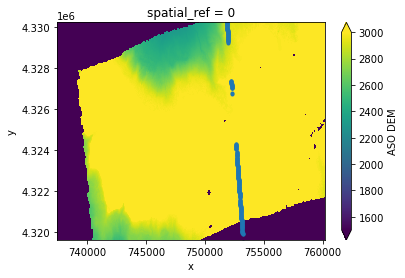

In [29]:
# Load the ASO DEM
path = 'ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m.tif'
da = rioxarray.open_rasterio(path, masked=True)
da = da.squeeze('band', drop=True)
da.name = 'ASO DEM'
df2.rio.write_crs('EPSG:26912', inplace=True) # Update CRS for ICESat-2

# Plot the IS2 data with an ESRI image
# Note that this plot only works if the Xarray coordinates are lat/lon
#df2['h_mean'].hvplot.image(x='lon', y='lat',rasterize=True,geo=True,
#                       xlabel='longitude',ylabel='latitude',cmap='viridis',
#                       frame_height=500, frame_width=500,
#                       xformatter='%.1f',yformatter='%.1f', tiles='ESRI', alpha=0.8)

# Plot the ICESat-2 track over the ASO DEM - currently struggling on overlaying the surface elevation on this plot. Also hvplot doesn't seem to like two rasters in one plot.
# Note that this plot only works if the Xarray coordinates are x/y
da.plot.imshow(vmin=1500, vmax=3000)
plt.plot(df2['x'], df2['y'], '.')
plt.ylim(min(da['y']), max(da['y']))

---
# CRYOSAT-2 SECTION

### Get Grand Mesa base map (code from Ben Smith's lidar tutorial)

In [30]:
# GDAL environment variables to efficiently read remote data
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

# SAR Data are stored in a public S3 Bucket
url = 's3://sentinel-s1-rtc-indigo/tiles/RTC/1/IW/12/S/YJ/2016/S1B_20161121_12SYJ_ASC/Gamma0_VV.tif'

# These Cloud-Optimized-Geotiff (COG) files have 'overviews', low-resolution copies for quick visualization
XR=[725000.0, 767000.0]
YR=[4.30e6, 4.34e6]
# open the dataset
daSen = rioxarray.open_rasterio(url, overview_level=1).squeeze('band')#.clip_box([712410.0, 4295090.0, 797010.0, 4344370.0])
daSen=daSen.where((daSen.x>XR[0]) & (daSen.x < XR[1]), drop=True)
daSen=daSen.where((daSen.y>YR[0]) & (daSen.y < YR[1]), drop=True)
dx=daSen.x[1]-daSen.x[0]
SAR_extent=[daSen.x[0]-dx/2, daSen.x[-1]+dx/2, np.min(daSen.y)-dx/2, np.max(daSen.y)+dx/2]

# Prepare coordinate transformations into the basemap coordinate system
from pyproj import Transformer, CRS
crs=CRS.from_wkt(daSen['spatial_ref'].spatial_ref.crs_wkt)
to_image_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lon, corners_lat=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
lonlims=[np.min(corners_lat), np.max(corners_lat)]
latlims=[np.min(corners_lon), np.max(corners_lon)]

mm = [SAR_extent[ii].values for ii in range(4)]

---
## Download Cryosat-2 data
### API to download the data is from Tyler Sutterly's read-cryosat-2 package
https://github.com/tsutterley/read-cryosat-2.git

Note that it took me a pretty long time (did not finish overnight) to download the files - I think the querying
is pretty slow. 

In [31]:
cs2_bound = gpd.read_file('CryoSat_Mask_4.0.kmz') #Load kmz with bounds of CryoSat-2 data

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


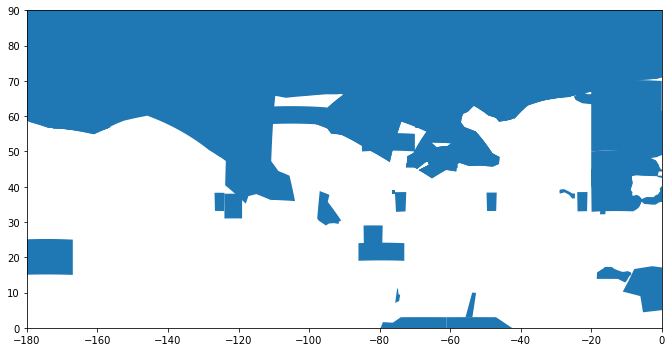

In [32]:
### Show everywhere that CryoSat-2 data exists (northern western hemisphere)
f1,a1 = plt.subplots(figsize=(10,5))
cs2_bound.plot(ax=a1)
a1.set_ylim(0,90)
a1.set_xlim(-180,0)
f1.tight_layout()

In [33]:
### Clip the extent of the CS2 geodataframe to the extent of Grand Mesa
bounding_box_GM = [-108.19, 39.03, -108.18, 39.04]
lon_pts = [bounding_box_GM[0],bounding_box_GM[2]]
lat_pts = [bounding_box_GM[1],bounding_box_GM[3]]
gdf = gpd.GeoDataFrame()
gdf['lat'] = lat_pts
gdf['lon'] = lon_pts
dim = 1  # define the length of the side of the square
geoms = []
for index, row in gdf.iterrows():
    ln = row.lon
    lt = row.lat
    geom = Polygon([(lon_pts[0], lat_pts[1]), (lon_pts[1], lat_pts[1]), (lon_pts[1], lat_pts[0]), (lon_pts[0], lat_pts[0])])
    geoms.append(geom)

gdf['geometry'] = geoms 
# gdf.crs = cs2_bound.crs
gdf.crs = crs="EPSG:4326"
inter = gpd.overlay(cs2_bound,gdf,how='intersection')
interUTM = inter.to_crs('EPSG:32612')

(4299996.445739257, 4339981.879096868)

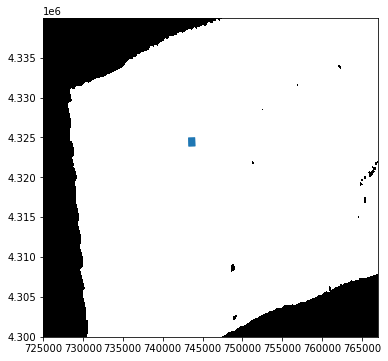

In [34]:
# Plot the interection between the SnowEx site and where CS2 dta exist
f1,a1=plt.subplots(figsize=(6,6))
a1.imshow(np.array(da)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
interUTM.plot(ax=a1)
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

In [35]:
### We are going to use Tyler Sutterly's esa_cryosat_sync script to download the data from whereever CS2 is hosted

# If the script is not present in the current directory, download it!
# if you are working in a different directory you can alter the path below
if not os.path.isfile('esa_cryosat_sync.py'):
    !wget https://raw.githubusercontent.com/tsutterley/read-cryosat-2/main/scripts/esa_cryosat_sync.py
else:
    print('ESA_cryosat_sync.py already present')

import esa_cryosat_sync as ecs  #You might have to resart the kernel, or alter your sys.path to get this to work

ESA_cryosat_sync.py already present


In [11]:
### Tyler's script is meant to be called from the command line
### Instead we are just calling the main function within the script
### CAUTION! THIS WILL TAKE A LONG TIME TO RUN

# ### Set the arguments for the data query
# DIRECTORY = 'CS2data' # this is the directory to which the downloaded data will be saved
# if not os.path.exists(DIRECTORY): #create that directory if it does not exist yet
#     os.mkdir(DIRECTORY)
# PRODUCT = 'SIR_SIN_L2' # this is the CS2 product you will download.
# BBOX = [-108.19, 39.03, -108.18, 39.04] # the bounding box for the data you want.
# YEARS = [2020] #must be a list, e.g. [2020] or [2019,2020]
# LIST = True #True/False: if true, it will only search the database and list the files that fit the query; if true will download
# #####
# ecs.esa_cryosat_sync(PRODUCT, YEARS=YEARS, BASELINE='D', DIRECTORY=DIRECTORY,
#     BBOX=BBOX, POLYGON=None, TIMEOUT=360, RETRY=5, LOG=False,
#     LIST=LIST, MODE=0o775, CLOBBER=False)

### End download cryosat section
---

In [36]:
### Get names of all CS2 files
### the CS2 files for me are in a subdirectory of the Present Working Directory
### you may need to alter the path below to be specific to your file structure
fnames = glob.glob('./CS2data/SIR_SIN_L2/2020/*/*.nc',recursive=True)

In [37]:
### if you want to load a single CS2 pass
ds     = xarray.open_dataset(fnames[1]) # load one file as an xarray dataset
hdf1   = ds.height_1_20_ku.to_dataframe() # put elevation track into a pandas dataframe. I am using the height_1_20_ku field; you will have to figure out what the different CS2 fields are!
gdf    = gpd.GeoDataFrame(hdf1, crs="EPSG:4326",geometry=gpd.points_from_xy(hdf1.lon_poca_20_ku, hdf1.lat_poca_20_ku)) # put into a geodataframe
gdfUTM = gdf.to_crs('EPSG:32612') # convert to EPSG:32612

In [38]:
'''
if you want to load all of the CS2 passes at once
xr.open_mfdataset was slow and did not work well
so open each file individually as an xarray dataset and put it into a dictionary
then each xarray dataset in the dictionary gets converted to its own geodataframe; again, those are all stored in a dictionary
'''
ds_dict     = {ii:xarray.open_dataset(fnames[ii]) for ii in range(len(fnames))}
mdf_dict    = {ii:ds_dict[ii].height_1_20_ku.to_dataframe() for ii in range(len(ds_dict))}
gdf_dict    = {ii:gpd.GeoDataFrame(mdf_dict[ii], crs="EPSG:4326",geometry=gpd.points_from_xy(mdf_dict[ii].lon_poca_20_ku, mdf_dict[ii].lat_poca_20_ku)) for ii in range(len(mdf_dict))}
gdfUTM_dict = {ii:gdf_dict[ii].to_crs('EPSG:32612') for ii in range(len(mdf_dict))}
for ii in range(len(gdfUTM_dict)):
    gdfUTM_dict[ii]['x'] = gdfUTM_dict[ii].geometry.x.values
    gdfUTM_dict[ii]['y'] = gdfUTM_dict[ii].geometry.y.values

(4299996.445739257, 4339981.879096868)

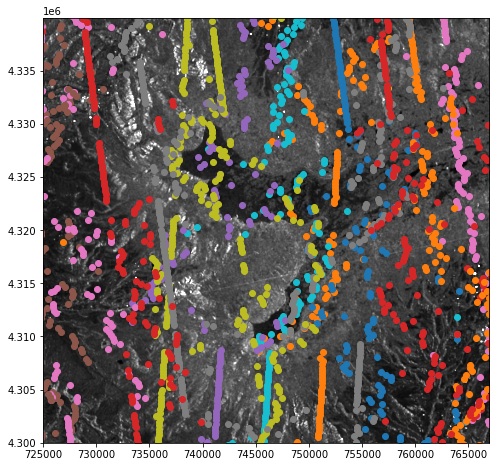

In [44]:
### plot the CS2 passes on the map

f1,a1=plt.subplots(figsize=(8,8))
a1.imshow(np.array(daSen)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
for ii in range(len(gdfUTM_dict)):
    gdfUTM_dict[ii].plot(ax=a1)
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

<AxesSubplot:xlabel='time_20_ku'>

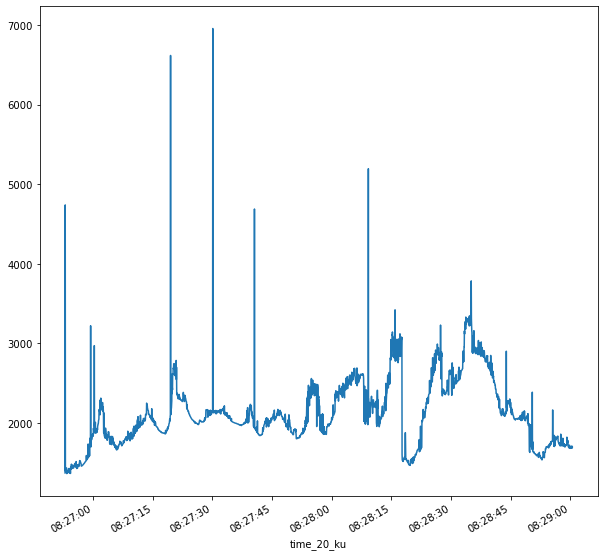

In [40]:
### plot elevations for one pass
f1,a1=plt.subplots(figsize = (10,10))
hdf1.height_1_20_ku.plot(ax=a1,label='1')

(4299996.445739257, 4339981.879096868)

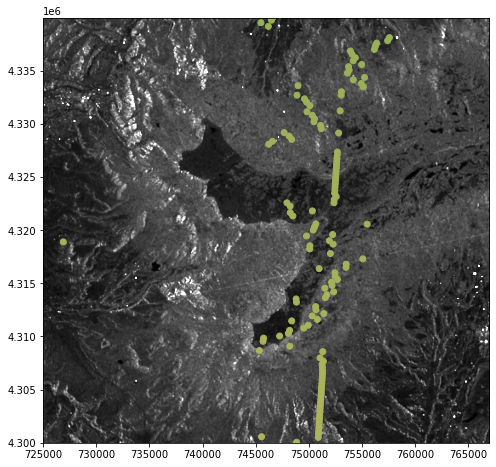

In [41]:
### plot one pass
f1,a1=plt.subplots(figsize=(8,8))
a1.imshow(np.array(daSen)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
gdfUTM.plot(ax=a1,c=gdfUTM.height_1_20_ku,cmap='gist_earth')
a1.set_xlim(mm[0],mm[1])
a1.set_ylim(mm[2],mm[3])

In [42]:
# Load the ASO DEM
path = '/home/jovyan/integration_station/snowflow/ASO_snowfree_GrandMesa_2016Sep26_fsrdemvf_mos_3m.tif'
da2 = rioxarray.open_rasterio(path, masked=True)
da2 = da2.squeeze('band', drop=True)
da2.name = 'ASO DEM'

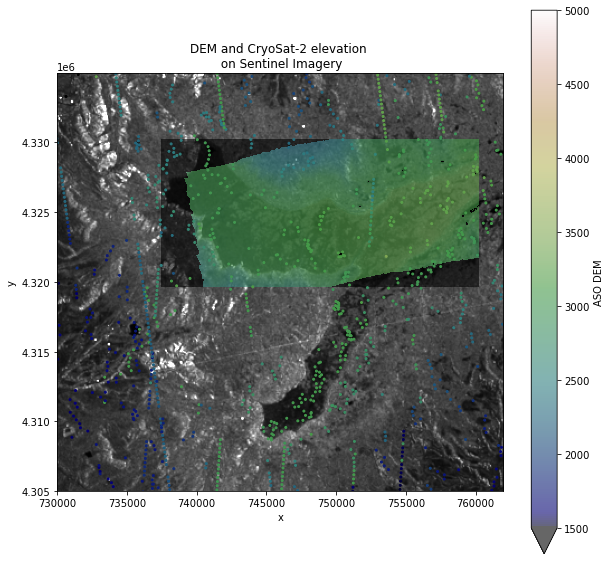

In [43]:
# plot sentinel image, DEM, and CS2 data
f1,a1= plt.subplots(figsize=(10,10))
a1.imshow(np.array(daSen)[::-1,:], origin='lower', extent=SAR_extent, cmap='gray', clim=[0, 0.5])
vmin = 1500
vmax = 5000
da2.plot.imshow(ax = a1,vmin=vmin, vmax=vmax,cmap='gist_earth',alpha=0.6)
lels = np.linspace(1500,5000,256)
for ii in range(len(gdfUTM_dict)):    
    cax1 = a1.scatter(gdfUTM_dict[ii]['x'], gdfUTM_dict[ii]['y'],4, c=gdfUTM_dict[ii]['height_1_20_ku'], cmap='gist_earth',vmin=vmin, vmax=vmax) #extend='both'
a1.set_xlim(mm[0]+5e3,mm[1]-5e3);
a1.set_ylim(mm[2]+5e3,mm[3]-5e3);
a1.set_aspect('equal');
a1.set_title('DEM and CryoSat-2 elevation \n on Sentinel Imagery');